**Retail Promotion Classification-Prediction Problem**

Through this project, we are aiming to use retail sales data to understand how the stores could run a promotional campaign targeting specific customer profiles.

This project would allow retail stores, particularly one without a lot of resources dedicated to promotional material, to optimize their promotional campaigns by identifying the most effective customer profiles to target with their marketing efforts. This approach can save retailers significant resources and effort by avoiding a standarized approach to promotions, which can be less effective and less efficient. Instead, stores can target specific customer segments based on their preferences in shopping categories, past purchasing behaviors, and other factors to maximize the effectiveness of their promotions.

Data Source: https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset

***Step 1: Data Cleaning and Preprocessing***

Imports

In [500]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import (
    StratifiedKFold,
    train_test_split, 
    cross_val_score,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
)


In [501]:
df = pd.read_csv('customer_shopping_data.csv')
# grabbing columns that are useful and dropping all else
df.drop(['invoice_no', 'customer_id', 'payment_method', 'invoice_date', 'shopping_mall'], axis=1, inplace=True)

# dropping rows we dont care about, like toys
df.drop(df[df['category'] == 'Toys'].index, inplace = True)
df.drop(df[df['category'] == 'Souvenir'].index, inplace = True)
df.drop(df[df['category'] == 'Books'].index, inplace = True)
df.drop(df[df['category'] == 'Shoes'].index, inplace = True)

# recalculating price column to include totals
df['total_price'] = (df['price'] * df['quantity'])
df.drop(['quantity', 'price'], axis=1, inplace=True)
df.head()

,gender,age,category,total_price
0,Female,28,Clothing,7502.00
2,Male,20,Clothing,300.08
5,Female,28,Clothing,7502.00
6,Female,49,Cosmetics,40.66
7,Female,32,Clothing,1200.32


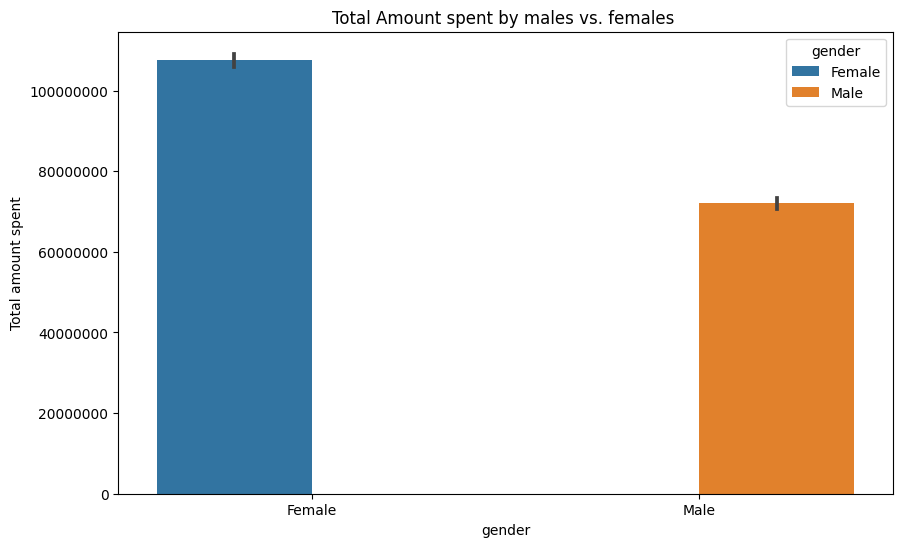

In [502]:
# plotting some statistics
plt.figure(figsize=(10,6))
sns.barplot(df,x='gender',y='total_price',hue = 'gender',estimator = sum)
plt.ylabel('Total amount spent')
plt.title('Total Amount spent by males vs. females ')
plt.ticklabel_format(style='plain',axis='y')
plt.show()

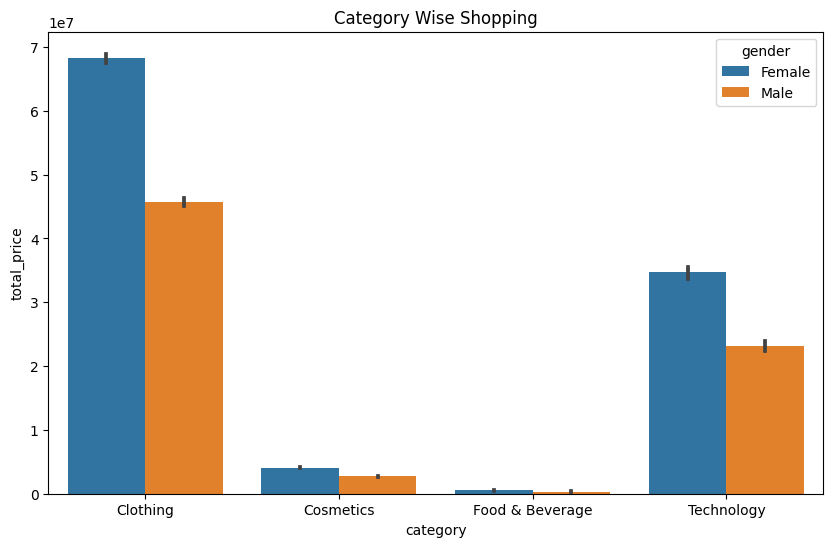

In [503]:
plt.figure(figsize=(10,6))
sns.barplot(df,x='category',y='total_price',hue = 'gender',estimator = sum)
plt.title('Category Wise Shopping')
plt.show()

In [504]:
# checking average price spent by gender per category
avg_price_spent_per=df.groupby(['gender','category'], as_index=False)['total_price'].mean()
avg_age_per=df.groupby(['gender','category'], as_index=False)['age'].mean()
print(avg_price_spent_per)
print("\n",avg_age_per)

   gender         category   total_price
0  Female         Clothing   3304.846775
1  Female        Cosmetics    448.376245
2  Female  Food & Beverage     57.396933
3  Female       Technology  11630.308621
4    Male         Clothing   3306.475999
5    Male        Cosmetics    452.312985
6    Male  Food & Beverage     57.637718
7    Male       Technology  11509.875931

    gender         category        age
0  Female         Clothing  43.381948
1  Female        Cosmetics  43.571665
2  Female  Food & Beverage  43.489209
3  Female       Technology  43.249581
4    Male         Clothing  43.449946
5    Male        Cosmetics  43.594160
6    Male  Food & Beverage  43.155727
7    Male       Technology  43.544417


In [505]:
df.groupby(['gender','category'], as_index=False)['total_price'].describe()

,gender,category,count,mean,std,min,25%,50%,75%,max
0,Female,Clothing,20652.0,3304.846775,2591.805146,300.08,1200.32,2700.72,4801.28,7502.00
1,Female,Cosmetics,9070.0,448.376245,351.210785,40.66,162.64,365.94,650.56,1016.50
2,Female,Food & Beverage,8804.0,57.396933,45.211737,5.23,20.92,47.07,83.68,130.75
3,Female,Technology,2981.0,11630.308621,9126.822685,1050.00,4200.00,9450.00,16800.00,26250.00
4,Male,Clothing,13835.0,3306.475999,2605.834237,300.08,1200.32,2700.72,4801.28,7502.00
5,Male,Cosmetics,6027.0,452.312985,352.884728,40.66,162.64,365.94,650.56,1016.50
6,Male,Food & Beverage,5972.0,57.637718,45.644014,5.23,20.92,47.07,83.68,130.75
7,Male,Technology,2015.0,11509.875931,8988.335801,1050.00,4200.00,9450.00,16800.00,26250.00


In [506]:
df.groupby(['gender','category'], as_index=False)['age'].describe()

,gender,category,count,mean,std,min,25%,50%,75%,max
0,Female,Clothing,20652.0,43.381948,14.979862,18.0,30.0,43.0,56.0,69.0
1,Female,Cosmetics,9070.0,43.571665,14.966309,18.0,31.0,44.0,56.0,69.0
2,Female,Food & Beverage,8804.0,43.489209,14.970409,18.0,31.0,43.0,56.0,69.0
3,Female,Technology,2981.0,43.249581,14.825544,18.0,30.0,43.0,56.0,69.0
4,Male,Clothing,13835.0,43.449946,15.025515,18.0,30.0,43.0,56.0,69.0
5,Male,Cosmetics,6027.0,43.594160,14.892899,18.0,31.0,44.0,57.0,69.0
6,Male,Food & Beverage,5972.0,43.155727,14.996070,18.0,30.0,43.0,56.0,69.0
7,Male,Technology,2015.0,43.544417,14.851730,18.0,31.0,43.0,56.0,69.0


In [507]:
# creating the class label
# label -> ['maybe', 'no', 'yes']
def assignNewLabels(row):
    # for book shoppers
    if row['category'] == "Technology" and row["total_price"] > 16800:
        return "yes"
    elif row['category'] == "Technology" and row["total_price"] <= 4200:
        return "no"
    elif row['category'] == "Technology" and row["total_price"] > 4200.0 and row["total_price"] <= 16800:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Clothing" and row["total_price"] > 4801.28:
        return "yes"
    elif row['category'] == "Clothing" and row["total_price"] <= 1200.32:
        return "no"
    elif row['category'] == "Clothing" and row["total_price"] > 1200.32 and row["total_price"] <= 4801.28:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Cosmetics" and row["total_price"] > 650.56:
        return "yes"
    elif row['category'] == "Cosmetics" and row["total_price"] <= 162.64:
        return "no"
    elif row['category'] == "Cosmetics" and row["total_price"] > 162.64 and row["total_price"] <= 650.56:
        return "maybe"
    
    # for clothing
    elif row['category'] == "Food & Beverage" and row["total_price"] > 83.68:
        return "yes"
    elif row['category'] == "Food & Beverage" and row["total_price"] <= 20.92:
        return "no"
    elif row['category'] == "Food & Beverage" and row["total_price"] > 20.92 and row["total_price"] <= 83.68:
        return "maybe"

In [508]:
df['Should_We_Market'] = df.apply(lambda row: assignNewLabels(row), axis=1)
df.head()

,gender,age,category,total_price,Should_We_Market
0,Female,28,Clothing,7502.00,yes
2,Male,20,Clothing,300.08,no
5,Female,28,Clothing,7502.00,yes
6,Female,49,Cosmetics,40.66,no
7,Female,32,Clothing,1200.32,no


Starting the Machine Learning Process 

In [509]:
df_dummy = pd.get_dummies(df[['gender', 'category', 'age', 'total_price']])
df_dummy.head()


,age,total_price,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology
0,28,7502.00,True,False,True,False,False,False
2,20,300.08,False,True,True,False,False,False
5,28,7502.00,True,False,True,False,False,False
6,49,40.66,True,False,False,True,False,False
7,32,1200.32,True,False,True,False,False,False


In [510]:
# converting labels to binary
#from sklearn.preprocessing import MultiLabelBinarizer
#mlb = MultiLabelBinarizer()
#print(mlb.fit_transform(df.Should_We_Market))
#list(mlb.classes_)
#df.head()

In [511]:
df.head()

,gender,age,category,total_price,Should_We_Market
0,Female,28,Clothing,7502.00,yes
2,Male,20,Clothing,300.08,no
5,Female,28,Clothing,7502.00,yes
6,Female,49,Cosmetics,40.66,no
7,Female,32,Clothing,1200.32,no


In [512]:
X = df_dummy
#y = mlb.fit_transform(df.Should_We_Market)
y = df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(69356, 8) (69356,)


Accuracy: 0.6015341138473961
F1 Score: 0.6578611995943382


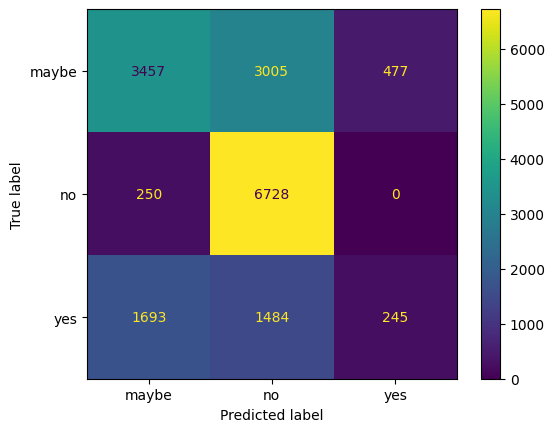

In [513]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

In [514]:
#%pip install imbalanced-learn
import imblearn
from collections import Counter
from numpy import *
import matplotlib.pyplot as plt

In [515]:
counter = Counter(y)
print(counter)

Counter({'maybe': 27724, 'no': 27647, 'yes': 13985})


We can see that accuracy is low, however, yes is the minoirty class which could be causing us to have misaligned weights in the model. 
We will try fixing this using random oversampling techiques. 

In [516]:
from sklearn.utils import resample

# Separate samples by class label
class_labels = df['Should_We_Market'].unique()
class_data = {}
for label in class_labels:
    class_data[label] = df[df['Should_We_Market'] == label]

# Determine the class with the most samples
majority_class = max(class_labels, key=lambda x: len(class_data[x]))

# Oversample the minority class to match the number of samples in the majority class
oversampled_data = []
for label in class_labels:
    if label != majority_class:
        oversampled_data.append(resample(class_data[label], replace=True, n_samples=len(class_data[majority_class])))

# Combine the oversampled data
oversampled_df = pd.concat([class_data[majority_class]] + oversampled_data)

In [517]:
oversampled_df.head()
counter = Counter(oversampled_df["Should_We_Market"])
print(counter)

Counter({'maybe': 27724, 'yes': 27724, 'no': 27724})


In [518]:
over_df_dummy = pd.get_dummies(oversampled_df[['gender', 'category', 'age', 'total_price']])
over_df_dummy.head()


,age,total_price,gender_Female,gender_Male,category_Clothing,category_Cosmetics,category_Food & Beverage,category_Technology
8,69,2700.72,False,True,True,False,False,False
17,42,47.07,True,False,False,False,True,False
29,29,365.94,False,True,False,True,False,False
33,51,4801.28,False,True,True,False,False,False
40,49,47.07,True,False,False,False,True,False


In [519]:
X = over_df_dummy
#y = mlb.fit_transform(df.Should_We_Market)
y = oversampled_df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(83172, 8) (83172,)


Accuracy: 0.6755638916943202
F1 Score: 0.677916525043255


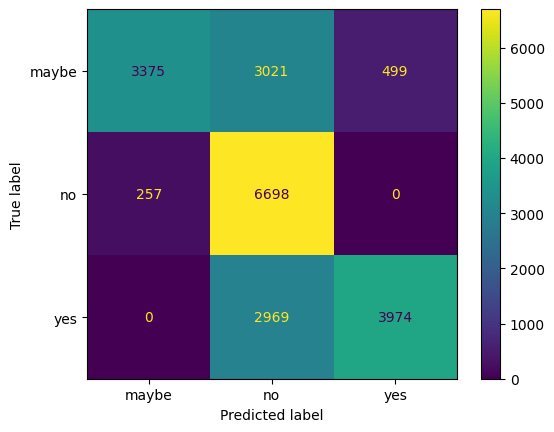

In [520]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)


cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

Accuracy went up by 6%! However, we want to fintune this a bit more. Let's run a random forest classifier to determine how important certain features are, and get rid of unimportant ones.

In [521]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = over_df_dummy
y = oversampled_df.Should_We_Market
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

# Get feature importances
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = importances.argsort()[::-1]
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. Feature {X.columns[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. Feature total_price (0.921912564766065)
2. Feature category_Clothing (0.025834743431469895)
3. Feature category_Food & Beverage (0.017921358400392183)
4. Feature category_Cosmetics (0.017591464705188832)
5. Feature category_Technology (0.014454169645138222)
6. Feature age (0.0020794179148189962)
7. Feature gender_Female (0.00011489488646015948)
8. Feature gender_Male (9.138625046667798e-05)


Looks like Age and Gender don't do much for our model, lets retry without these features! (Still oversampling our original dataset)

In [522]:
over_df_dummy = pd.get_dummies(oversampled_df[['total_price', 'category']])

X = over_df_dummy
#y = mlb.fit_transform(df.Should_We_Market)
y = oversampled_df.Should_We_Market

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=125
)

(83172, 5) (83172,)


Accuracy: 0.6755638916943202
F1 Score: 0.677916525043255


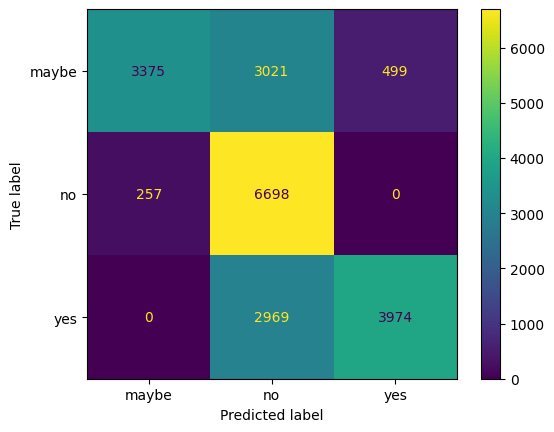

In [523]:
# Build a Gaussian Classifier
model = GaussianNB()

# Model training
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")

print("Accuracy:", accuracy)
print("F1 Score:", f1)

cm = confusion_matrix(y_test, y_pred, labels=["maybe", "no", "yes"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["maybe", "no", "yes"])
disp.plot();

# interpret results in writeup using https://www.v7labs.com/blog/confusion-matrix-guide

We went up by 1%, still better than our original 60%. 